# GTZAN Dataset Loading and Preprocessing

This notebook demonstrates how to load and preprocess the GTZAN dataset for music genre classification.

**GTZAN Dataset**: Contains 1000 audio tracks (30 seconds each) across 10 genres.

In [1]:
import torch
print(torch.__version__)

2.8.0+cpu


In [2]:
import os
import numpy as np
import librosa
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

## Dataset Configuration

In [3]:
# Configure paths
GTZAN_PATH = '../data/gtzan' 
SAMPLE_RATE = 22050
DURATION = 30  # seconds
N_MELS = 128

# GTZAN genres
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 
          'jazz', 'metal', 'pop', 'reggae', 'rock']

## GTZAN Dataset Class

In [4]:
class GTZANDataset(Dataset):
    """PyTorch Dataset for GTZAN music genre classification."""
    
    def __init__(self, root_dir, sample_rate=22050, duration=30, transform=None):
        """
        Args:
            root_dir (string): Directory with all the audio files organized by genre
            sample_rate (int): Target sample rate for audio
            duration (int): Duration in seconds
            transform (callable, optional): Optional transform to be applied on audio
        """
        self.root_dir = root_dir
        self.sample_rate = sample_rate
        self.duration = duration
        self.transform = transform
        self.genres = GENRES
        self.genre_to_idx = {genre: idx for idx, genre in enumerate(self.genres)}
        
        # Build file list
        self.files = []
        self.labels = []
        
        for genre in self.genres:
            genre_path = os.path.join(root_dir, genre)
            if os.path.exists(genre_path):
                for filename in os.listdir(genre_path):
                    if filename.endswith('.wav'):
                        self.files.append(os.path.join(genre_path, filename))
                        self.labels.append(self.genre_to_idx[genre])
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        audio_path = self.files[idx]
        label = self.labels[idx]
        
        # Load audio
        waveform, sr = torchaudio.load(audio_path)
        
        # Resample if necessary
        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.sample_rate)
            waveform = resampler(waveform)
        
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Pad or truncate to fixed duration
        target_length = self.sample_rate * self.duration
        if waveform.shape[1] > target_length:
            waveform = waveform[:, :target_length]
        elif waveform.shape[1] < target_length:
            padding = target_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))
        
        if self.transform:
            waveform = self.transform(waveform)
        
        return waveform, label

## Mel-Spectrogram Transform

In [5]:
def get_mel_spectrogram_transform(sample_rate=22050, n_mels=128):
    """Create mel-spectrogram transform."""
    return torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=2048,
        hop_length=512,
        n_mels=n_mels
    )

## Example Usage

In [6]:
# Create dataset instance
# Note: Uncomment and update the path to use
dataset = GTZANDataset(GTZAN_PATH, sample_rate=SAMPLE_RATE, duration=DURATION)
print(f"Dataset size: {len(dataset)}")
print(f"Genres: {dataset.genres}")

Dataset size: 1000
Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


## Visualize Sample

f:\Code\NLP\Tagging-Music-Sequences\venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


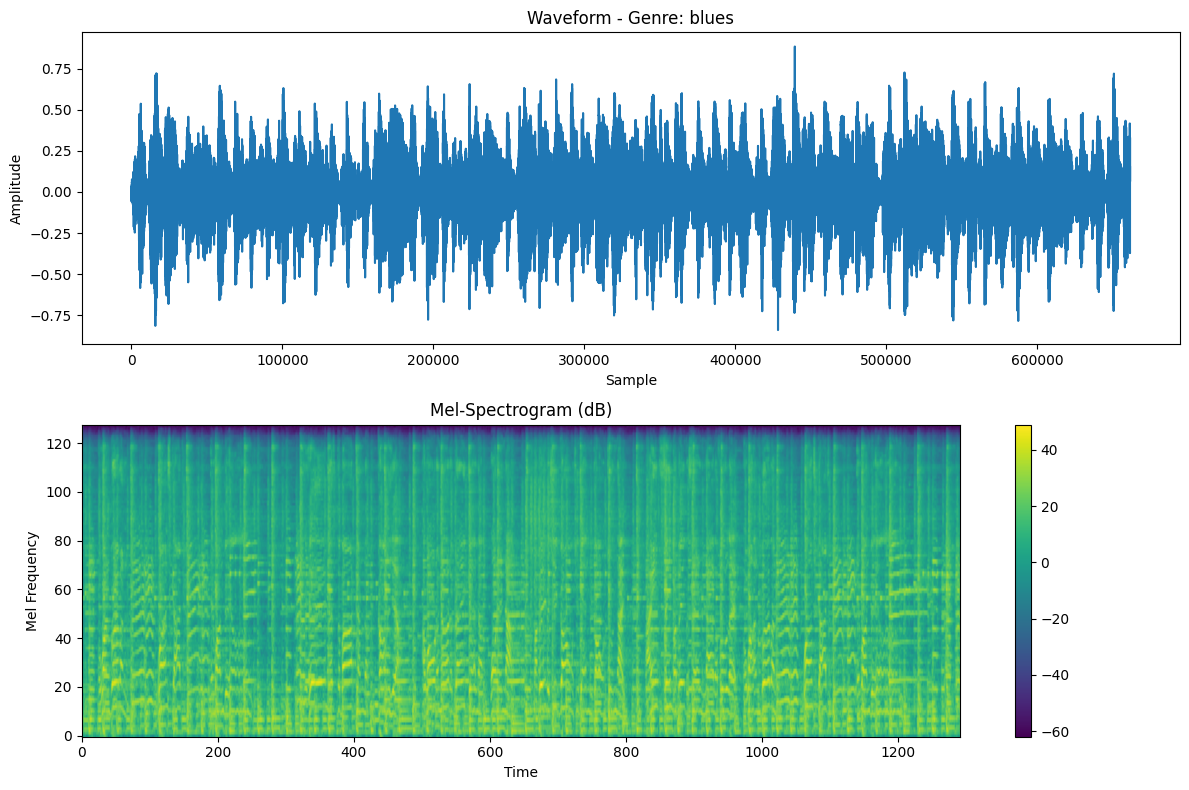

In [7]:
def visualize_sample(dataset, idx=0):
    """Visualize a sample from the dataset."""
    waveform, label = dataset[idx]
    
    # Create mel-spectrogram
    mel_transform = get_mel_spectrogram_transform(dataset.sample_rate)
    mel_spec = mel_transform(waveform)
    mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot waveform
    axes[0].plot(waveform[0].numpy())
    axes[0].set_title(f'Waveform - Genre: {dataset.genres[label]}')
    axes[0].set_xlabel('Sample')
    axes[0].set_ylabel('Amplitude')
    
    # Plot mel-spectrogram
    im = axes[1].imshow(mel_spec_db[0].numpy(), aspect='auto', origin='lower')
    axes[1].set_title('Mel-Spectrogram (dB)')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Mel Frequency')
    plt.colorbar(im, ax=axes[1])
    
    plt.tight_layout()
    plt.show()

    
visualize_sample(dataset, idx=0)

## Create DataLoader

In [10]:
def create_dataloaders(dataset, batch_size=16, train_split=0.8):
    """Create train and validation dataloaders."""
    train_size = int(train_split * len(dataset))
    val_size = len(dataset) - train_size
    
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    
    return train_loader, val_loader

train_loader, val_loader = create_dataloaders(dataset, batch_size=16)